# Calculate the GW modes for each exoplanet that has the needed parameters in the dbase.

In [1]:
# Started WEG  20180320.  A Pythonic version of Mathematica

# References
P. Amaro-Seoane et al. "Triplets of supermassive black holes: astrophysics, gravitational waves and detection," MNRAS 402 2308-2320 (2010).

P. C. Peters and J. Mathews, "Gravitational Radiation from Point Masses in a Keplerian Orbit," Phys. Rev. 131 (1963) 435-440.

Michele Maggiore, "Gravitational Waves. Volume 1: Theory and Experiments," Oxford Univ. Press, 2008.

In [2]:
import sys, os
import numpy as np
import pandas as pd
import gwTools as gwt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.interpolate as spint

## Directories, toward using dbase

In [3]:
thisDir = os.getcwd()  # This is the /python subdirectory.
cvsDir = thisDir + '/../dbases/'  # Will the /../ work on non-Unices?
pixDir = thisDir + '/../pix/'

## Read the CVS and Filter the data, see ExopDBase.ipynb and re-run it for updating the dbase.

In [4]:
cvsFileName = cvsDir + 'exopP_20180325_114502.csv'
print('Using database file ' + cvsFileName)
ifile = open(cvsFileName, 'r')
print(ifile.readline(), '\n', ifile.readline() )  #Print a couple of lines and reset the pointer.

ifile.seek(0);

Using database file /home/gabella/Documents/astro/exop/exoplanetsMath/python/../dbases/exopP_20180325_114502.csv
pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
 
 HD 142022 A,b,Radial Velocity,1928.00000000,3.030000,0.530000,5.10000,35.87,0.99,2014-05-14,27.88



In [5]:
dbData = pd.read_csv(ifile)  # Read in the whole file to a Panda Dataframe, handles NaN's nicely, see below.
ifile.close()

In [6]:
dbData.head(15)  # NaN's show up when the field has no data.  Need both masses, eccentricity, semimajor axis, 
# and distance.

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.000000,3.0300,0.5300,5.100,35.87,0.99,2014-05-14,27.88
1,HD 39091,b,Radial Velocity,2151.000000,3.3800,0.6405,10.270,18.21,1.10,2014-07-23,54.92
2,HD 137388 A,b,Radial Velocity,330.000000,0.8900,0.3600,0.223,38.45,0.86,2014-05-14,26.01
3,GJ 3021,b,Radial Velocity,133.710000,0.4900,0.5110,3.370,17.62,0.90,2014-05-14,56.76
4,HD 63454,b,Radial Velocity,2.818049,0.0368,0.0000,0.398,35.80,0.84,2015-03-26,27.93
5,HD 212301,b,Radial Velocity,2.245715,0.0360,0.0000,0.450,52.72,1.27,2014-05-14,18.97
6,CHXR 73,b,Imaging,NaN,210.0000,NaN,12.569,NaN,0.35,2014-05-14,NaN
7,CT Cha,b,Imaging,NaN,440.0000,NaN,17.000,165.00,NaN,2014-05-14,NaN
8,HD 196067,b,Radial Velocity,3638.000000,5.0200,0.6600,6.900,43.57,1.29,2014-05-14,22.95
9,HD 68402,b,Radial Velocity,1103.000000,2.1800,0.0300,3.070,78.00,1.12,2016-11-10,12.82


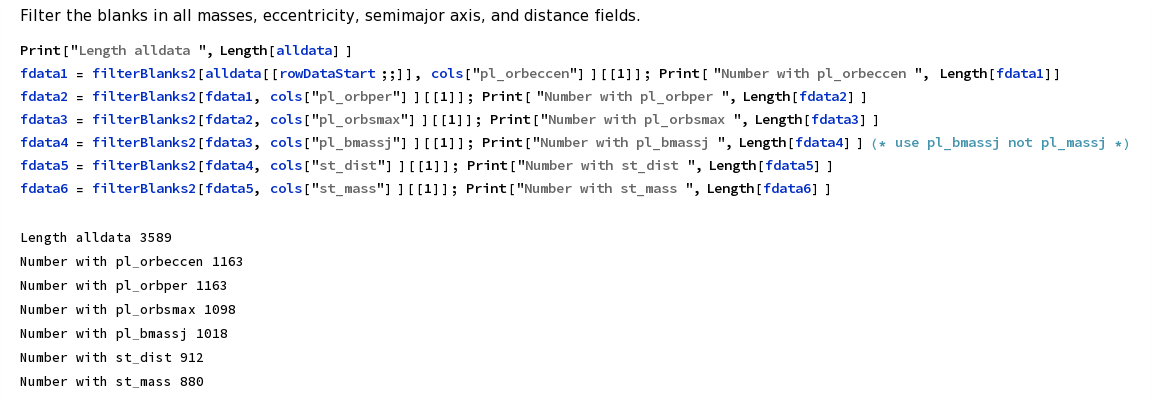

In [7]:
# From the Mathematica file for filtering, data from older 20180201_092937.csv.
from IPython.display import Image
Image(filename = 'filteringMathematica.png')

In [8]:
len(dbData)

3706

In [9]:
# {"pl_hostname", "pl_letter", "pl_discmethod", "pl_orbper", \
# "pl_orbsmax", "pl_orbeccen", "pl_bmassj", "st_dist", "st_mass", \
# "rowupdate", "st_plx"}
print('Length all data, dbData ', len(dbData) )
aData = dbData.dropna(axis = 0, how = 'any', subset = ['pl_orbeccen'])
print('Length with pl_orbeccen\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbper'])
print('Length with pl_orbper\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbsmax'])
print('Length with pl_orbsmax\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_bmassj'])
print('Length with pl_bmassj\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['st_dist'])
print('Length with st_dist\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['st_mass'])
print('Length with st_mass\t', len(aData) )

Length all data, dbData  3706
Length with pl_orbeccen	 1170
Length with pl_orbper	 1170
Length with pl_orbsmax	 1105
Length with pl_bmassj	 1024
Length with st_dist	 918
Length with st_mass	 908


In [10]:
#  So adata is the working exoplanet data after filtering as a Panda DataFrame.  Later should consider filling in 
#  missing data with Kepler or other calculations.


##  Physical Constants, use the following and the ones from scipy.constants that show up in  gwTools.py!!

In [11]:
# Copied from JustStrainPlots.nb Mathematica for consistency.
from scipy.constants import speed_of_light, gravitational_constant, c, G, pi

massSun = 1.989e30; #(*kg *)
massJ = 1.898e27; #(* kg *)
massE = 5.972e24; #(* kg *)
massJe = massJ/massE; #(* Jupiter mass is 317.9 earth masses *)
massJs = massJ/massSun; #(* relative to the sun's mass *)

pc = 30.86e15; #(* meters, parsec *)
au = 149.6e9; #(* meters, astron unit *)
cee = 299792458.0; #(* meters/s, speed of light *)

cee = 299792458.0; #(* meters/s, speed of light *)
print('Compare my cee ', cee, ' and scipy.constants ', speed_of_light)
cee = speed_of_light # Use the scipy.constants one.
secsYear = 365.24*24.0*3600.0; #(* s, number of seconds in a year *)
secsDay = 24.0*3600.0; #(* s, number of seconds in a day *)

bigG = 6.67408e-11; #(* SI Gravitational constant, m^3/kg/s *)
print('Compare my bigG ', bigG, ' and scipy.constants ', gravitational_constant)
bigG = gravitational_constant

rscon = 2*bigG*massSun/(cee*cee) #(* 2955.43 m, solar mass Scharzschild radius *)
lunits = bigG*massSun/(cee*cee) #(* meters per solar mass, units of G=c=1, no factor
#of 2 as in Schwarzschild radius *)
masscon = lunits; #(* m, G Msol/c^2, for 1 solar mass *)
powercon = cee**5/bigG  #(* 3.628e52 W, c^5/G, W/unit since P is dimensionless in G=c=1 units *)
energycon = (cee**4)/bigG  #(* 1.210e44 J/m, c^4/G *)

Compare my cee  299792458.0  and scipy.constants  299792458.0
Compare my bigG  6.67408e-11  and scipy.constants  6.67408e-11


## Calculate some GW amplitudes for each exoplanet.

Text(0.5,1,'The n-star, where the g(n,e) curve\n comes back to 1/20th the peak value')

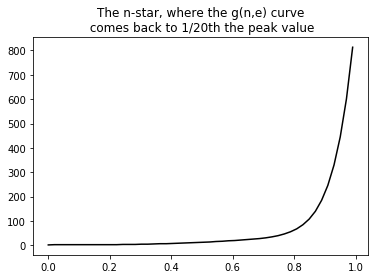

In [12]:
ecc = np.linspace(0., 0.99, 50)
nstar = [ gwt.aNmax(uu) for uu in ecc ]
plt.plot(ecc, nstar, 'k-')
plt.title('The n-star, where the g(n,e) curve\n comes back to 1/20th the peak value')

In [13]:
aData.head(8)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.000000,3.0300,0.5300,5.100,35.87,0.99,2014-05-14,27.88
1,HD 39091,b,Radial Velocity,2151.000000,3.3800,0.6405,10.270,18.21,1.10,2014-07-23,54.92
2,HD 137388 A,b,Radial Velocity,330.000000,0.8900,0.3600,0.223,38.45,0.86,2014-05-14,26.01
3,GJ 3021,b,Radial Velocity,133.710000,0.4900,0.5110,3.370,17.62,0.90,2014-05-14,56.76
4,HD 63454,b,Radial Velocity,2.818049,0.0368,0.0000,0.398,35.80,0.84,2015-03-26,27.93
5,HD 212301,b,Radial Velocity,2.245715,0.0360,0.0000,0.450,52.72,1.27,2014-05-14,18.97
8,HD 196067,b,Radial Velocity,3638.000000,5.0200,0.6600,6.900,43.57,1.29,2014-05-14,22.95
9,HD 68402,b,Radial Velocity,1103.000000,2.1800,0.0300,3.070,78.00,1.12,2016-11-10,12.82


## Create a numpy array of GW strain amplitudes for that planet and append to the table.

In [14]:
# Actually append n_min, n_max, numpy array of GW strains h.
# In the Mathematica JustStrainPlots.nb, about 40% down, calc hhVfreq first time.

hhmodesCol = []  # Setup a list of the hhmodes that will be appended to the dataframe.
modesCol = [] # The modes set acually used for the calculation, int(modeMin) to int(modeMax)+1
freq0Col = [] # Collect the orbital frequency that was used.

for irow in range(len(aData)):
    # Calculate the SI parameters needed by the strains and the strain "front coefficient."
    
    orbeccen = aData['pl_orbeccen'].values[irow]
    modeMax = gwt.aNmax( orbeccen )  # The "max" mode number where g(n,e) returns to 1/20th its peak value.
    modeMin = gwt.aNmin( orbeccen )  # Either 1 for e>0 or 2 for e=0.
    #
    m1 = aData['pl_bmassj'].values[irow]*massJ
    m2 = aData['st_mass'].values[irow]*massSun
    smax = aData['pl_orbsmax'].values[irow]*au
    dL = aData['st_dist'].values[irow]*pc
    freq0 = 1.0/(aData['pl_orbper'].values[irow]*secsDay)
    #aData['pl_orbper']*secsDay
    frontCoeff = np.power(bigG,5/3.)/cee**4 * 2 * np.sqrt(32/5.) * np.power( gwt.chirpM(m1,m2), 5/3.)*\
    np.power((2*np.pi*freq0), 2/3.)/dL
    if irow > 6 and irow < 15:
        print('irow is ', irow, ' ,frontCoeff is ', frontCoeff, ' pl_orbeccen is ', orbeccen)

    # Now loop over the GW modes.
    hhmodes = [ frontCoeff*gwt.ggSimp(uu, orbeccen) for uu in range(int(modeMin), int(modeMax)+1)  ]
    modes = [ uu for uu in range(int(modeMin), int(modeMax)+1)  ]
    
    # Append to the list.
    hhmodesCol.append( hhmodes )
    modesCol.append( modes )
    freq0Col.append( freq0 )
        

irow is  7  ,frontCoeff is  4.6311021600204593e-26  pl_orbeccen is  0.03
irow is  8  ,frontCoeff is  2.169114619938696e-26  pl_orbeccen is  0.41
irow is  9  ,frontCoeff is  2.5108674723286658e-25  pl_orbeccen is  0.638
irow is  10  ,frontCoeff is  6.772473061612905e-26  pl_orbeccen is  0.85
irow is  11  ,frontCoeff is  2.4969184134452682e-26  pl_orbeccen is  0.08
irow is  12  ,frontCoeff is  4.643709659681133e-25  pl_orbeccen is  0.0
irow is  13  ,frontCoeff is  7.140502406734836e-26  pl_orbeccen is  0.29
irow is  14  ,frontCoeff is  1.2172309568518269e-25  pl_orbeccen is  0.54


In [15]:
print( len(hhmodesCol[0] ) )
print( hhmodesCol[0] )
print( modesCol[0] )

15
[3.296673459110096e-27, 1.781834259812521e-26, 7.045961566633912e-26, 1.0708553482104247e-25, 1.1337448689631755e-25, 9.885489074022218e-26, 7.630426257751142e-26, 5.416032215296158e-26, 3.6156874548614144e-26, 2.303433227542831e-26, 1.4142572300033822e-26, 8.427690786846201e-27, 4.8997536773335406e-27, 2.790229896023936e-27, 1.5611286255233893e-27]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [16]:
#Append the hhmodesCol to the dataframe, for ease of getting at the other attributes.
aData['freq0'] = freq0Col
aData['modes'] = modesCol
aData['hhmodes'] = hhmodesCol

In [17]:
aData.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes
0,HD 142022 A,b,Radial Velocity,1928.0,3.03,0.5300,5.100,35.87,0.99,2014-05-14,27.88,6.003150e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3.296673459110096e-27, 1.781834259812521e-26,..."
1,HD 39091,b,Radial Velocity,2151.0,3.38,0.6405,10.270,18.21,1.10,2014-07-23,54.92,5.380788e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.6160381095729894e-26, 1.9386780309789621e-2..."
2,HD 137388 A,b,Radial Velocity,330.0,0.89,0.3600,0.223,38.45,0.86,2014-05-14,26.01,3.507295e-08,"[1, 2, 3, 4, 5, 6, 7]","[2.183959500231702e-28, 6.2753080010927265e-27..."


## Use the calculated data and the Larson or Cornish S_n(f) curve averaged/integrated over 1 year, or 4 years.

The Larson curve from http://www.srl.caltech.edu/~shane/sensitivity/MakeCurve.html , for dimensionless strain says 1 year integration time (?)

In [18]:
# Load one or other of the Larsen curves
larson1Yr = 'scg_5672_hdimless_1yearInten.dat';  # This is likely the wrong arm lengths, etc, even for Larson.
larsonDimless1Yr = pd.read_csv( thisDir + '/../' + larson1Yr, header=None, delim_whitespace=True, \
                               names=['freq[Hz]', 'h[dimless]'], skiprows=22 )
larsonDimless1Yr.head(3)

,freq[Hz],h[dimless]
0,9.765035e-08,1.465146e-15
1,9.992561e-08,1.399184e-15
2,1.022538e-07,1.336193e-15


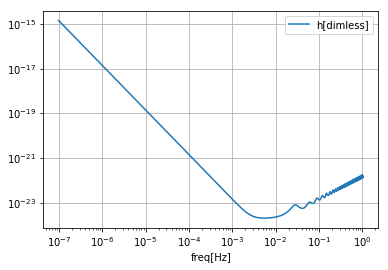

In [19]:
larsonDimless1Yr.plot(x = 'freq[Hz]', y = 'h[dimless]', logy=True, logx=True, grid=True)

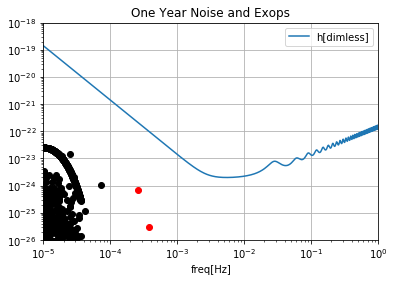

In [20]:
# plotting different dataframes in same plot
#ax = df1.plot()
#df2.plot(ax=ax)

ax = larsonDimless1Yr.plot(x = 'freq[Hz]', y = 'h[dimless]', logy=True, logx=True, grid=True)
for irow in range(len(aData)):
#for irow in range(3):
    aa = aData['freq0'].values[irow]
    xx = [aa * uu for uu in aData['modes'].values[irow]  ] 
    yy = aData['hhmodes'].values[irow]
    acolor = 'ko'
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438':
        if aData['pl_letter'].values[irow] == 'b':
            acolor = 'ro'
    ax.plot( xx, yy, acolor)
    ax.set_ylim((1e-26, 1e-18) )
    ax.set_xlim((1e-5, 1.0) )
    ax.set_title('One Year Noise and Exops')
    

In [21]:
for irow in range(len(aData) ):
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438' and \
    aData['pl_letter'].values[irow] == 'b':
        theRow = irow
        print( aData.values[irow] )

['PSR J1719-1438' 'b' 'Pulsar Timing' 0.09070629 0.0044 0.06 1.2 1200.0
 1.4 '2014-05-14' nan 0.0001275994649772808 list([1, 2, 3])
 list([3.9137497862038733e-28, 7.095173269667969e-25, 2.9121239158438164e-26])]


In [22]:
gwt.aNmax(0.06)  # If e>0 always have at least three modes, n = 1,2,3 .

3.0

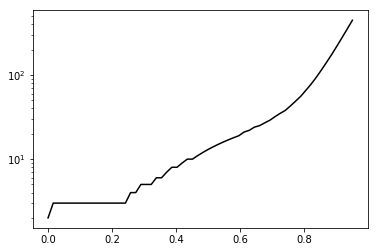

In [23]:
xx = np.linspace(0,0.95, 60)
yy= [ gwt.aNmax(uu) for uu in xx ]
plt.semilogy(xx, yy, 'k-')

## Calculate the signal-to-noise ratio for each planet.

Testing the linear interp in log-log space of the dep and indep variables.


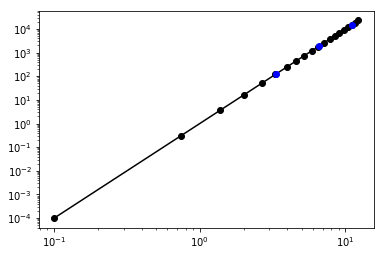

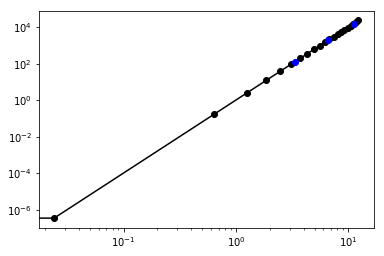

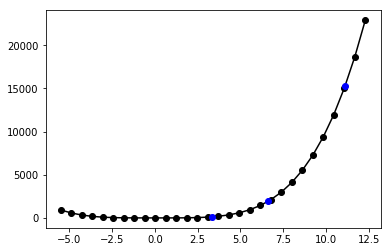

In [24]:
# Will need to interpolate the S_n(f) functions.
# Do the linear interpolation in the log-space since it is so linear there.
class snLinInterp:

    """Input the numpy arrays of freqs and sns and returns a class with
    a __call__ function.  Not good checks for values <=0 or if you are interpolating
    outside the range it was setup in, so use carefully.
    """
    def __init__(self, freqs, sns):
        from scipy.interpolate import interp1d
        # Check lenght of arrays agree.
        if len(freqs) != len(sns):
            print('***class snLinInterp: error, arrays lengths disagree, len(freqs) ', len(freqs), ' and '\
                 'len(sns) is ', len(sns) )
        else:
        # Check for zero in each array.  Cannot use x[x>0] as usual, need arrays coordinated.
            idrop = []
            for ii in range(len(freqs)):
                if freqs[ii] <= 0 or sns[ii] <= 0:
                    idrop.append(ii)

            self.freqs = np.delete(freqs,idrop)
            self.sns = np.delete(sns, idrop)
            self.logFreqs = np.log10(self.freqs)
            self.logSns = np.log10(self.sns)
            self.myInterp1D = interp1d(freqs, sns)  # Leave it linear for now. scipy.interpolate.
            self.minFreq = np.min(self.freqs)
            self.maxFreq = np.max(self.freqs)  # Can only interp between the values min freq and max.
        
    def __call__(self, uu):  # Checking for negatives and zeros is a pain, just do not do it for now!!
        return( self.myInterp1D(uu) )
        
xx = np.linspace(0.1, 12.3, 20)
yy = np.power(xx,4)
snInterp = snLinInterp(xx, yy )  # Has the __call__ method, so makes a 1D function.
xint = [3.33, 6.6, 11.11]
yint = snInterp(xint)
ax = plt.loglog(xx,yy,'ko-', xint, yint, 'bo')
# set_title('Testing the linear interp in log-log space of the dep and indep variables.')
print( 'Testing the linear interp in log-log space of the dep and indep variables.' )
plt.show()

# Test handling of the negatives and zero values!
xx = np.linspace(-5.5, 12.3, 30)
yy = np.power(xx,4)
snInterp2 = snLinInterp(xx, yy) # trying negatives for x but all positives for y, should drop both values.

xint = np.array([3.33, 6.6, 11.11])
yint = snInterp(xint)
plt.loglog(xx,yy,'ko-', xint, yint, 'bo')
plt.show()
plt.plot(xx,yy,'ko-', xint, yint, 'bo')
plt.show()

In [25]:
# Setup the interpolating for the S_n(f) int he range below f = 2e-3 Hz.
mySnInterp = snLinInterp( lar)


# It is the sum over the modes.
intTime = 1.0*secsYear  # Integration time in seconds.

SNRCols = []
for irow in range(len(aData) ):
    freq0 = aData['freq0'].values[irow]
    modes= aData['modes'].values[irow]
    hhmodes = aData['hhmodes'].values[irow]
    SNRsum = 0.0
    for jmodes in range(len(modes) ):
        
        
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-25-65a7d30be163>, line 18)